In [ ]:
#hide
#colab
# attach gdrive holding repo
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#default_exp multi_core.lr_find

# Multi Core LR Find XLA Extensions

> Classes to replace LRFinder and patches to Learner
to support running lr_find using multi core TPUs

Modifications to existing callback `LRFinder` are needed in order to run `lr_find` using multiple TPU cores. An equivalent `xla_lr_find` method is patched to `Learner` so it can run on multiple TPU cores.

In [ ]:
#hide
#colab
# install pytorch 1.7.1 b/c fastai doesn't support pytorch 1.8 just yet
!pip install -Uqq --no-cache-dir torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchtext==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html


In [ ]:
#hide
#colab
!pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp37-cp37m-linux_x86_64.whl
# VERSION = "nightly"  #@param ["1.5", "1.7" , "20200325", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

     |████████████████████████████████| 133.6MB 83kB/s 
     |████████████████████████████████| 61kB 2.7MB/s 
ERROR: earthengine-api 0.1.254 has requirement google-api-python-client>=1.12.1, but you'll have google-api-python-client 1.8.0 which is incompatible.


In [ ]:
#hide
#colab
# !pip install -Uqq git+https://github.com/fastai/fastai.git 
!pip install -Uqq fastai --upgrade

     |████████████████████████████████| 194kB 5.4MB/s 
     |████████████████████████████████| 61kB 5.0MB/s 


In [ ]:
#hide
#colab
!pip install -qqq nbdev

     |████████████████████████████████| 51kB 3.2MB/s 
     |████████████████████████████████| 51kB 4.1MB/s 


In [ ]:
#hide
#colab
# !pip install -Uqq git+https://github.com/butchland/fastai_xla_extensions.git

In [ ]:
#hide
#colab
# !pip install -Uqq git+https://github.com/butchland/my_timesaver_utils.git

In [ ]:
#hide
#colab
!curl -s https://course19.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:
#hide
#colab
%cd /content
!ln -s /content/drive/MyDrive/fastai_xla_extensions fastai_xla_extensions

/content


In [ ]:
#hide
!pip freeze | grep torch
!pip freeze | grep fast
!pip freeze | grep timesaver
!pip freeze | grep nbdev

torch==1.7.1+cu101
torch-xla==1.7
torchsummary==1.5.1
torchtext==0.8.0
torchvision==0.8.2+cu101
fastai==2.2.7
fastcore==1.3.19
fastdtw==0.3.4
fastprogress==1.0.0
fastrelease==0.1.11
fastrlock==0.5
nbdev==1.1.13


In [ ]:
# hide
# start of kernel

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
#colab
%cd /content/fastai_xla_extensions

/content/drive/MyDrive/fastai_xla_extensions


In [ ]:
#exporti
from fastai_xla_extensions.utils import xla_imported
from fastai_xla_extensions.multi_core.base import *
from fastai_xla_extensions.multi_core.callback import *
from fastai_xla_extensions.multi_core.learner import *
from fastai_xla_extensions.misc_utils import *
from fastai_xla_extensions.core import *


In [ ]:
#hide
#colab
%cd /content

/content


In [ ]:
#exporti
try:
    import torch_xla
except:
    pass


In [ ]:
#exporti
if xla_imported():
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.xla_multiprocessing as xmp
    import torch_xla.distributed.parallel_loader as pl

In [ ]:
#hide
#local
# fake out torch_xla modules if not running on xla supported envs
if not xla_imported():
    # replace torch xla modules with fake equivalents
    from types import SimpleNamespace
    torch_xla = SimpleNamespace (
    )
    from typing import Union,BinaryIO
    import os
    import pickle
    import torch.cuda

    def fake_opt_step(opt,barrier=False):
        opt.step()
        
    def fake_device(n=None, devkind=None):
        gpu_available = torch.cuda.is_available()
        if gpu_available:
            return torch.device(torch.cuda.current_device()) 
        return torch.device('cpu')

    def fake_save(obj, f: Union[str, os.PathLike, BinaryIO], 
                master_only=True, global_master=False): 
        return torch.save(obj,f,pickle_module=pickle, 
                        pickle_protocol=2, 
                        _use_new_zipfile_serialization=True)
    def fake_rate():
        return 230.20

    def fake_global_rate():
        return 830.10

    def fake_add(*args,**kwargs):
        pass

    def fake_RateTracker():
        return SimpleNamespace(
            rate = fake_rate,
            global_rate = fake_global_rate,
            add = fake_add
        )
    def fake_xrt_world_size():
        return 1
    def fake_get_ordinal():
        return 0
    xm = SimpleNamespace(
        optimizer_step = fake_opt_step,
        xla_device = fake_device,
        save = fake_save,
        RateTracker = fake_RateTracker,
        master_print = print,
        xrt_world_size = fake_xrt_world_size,
        get_ordinal = fake_get_ordinal
    )

    def fake_metrics_report():
        return "Fake Metrics Report \n\n\n\n"
    met = SimpleNamespace (
        metrics_report = fake_metrics_report
    )

    class FakeParallelLoader:
        def __init__(self, loader, *args):
            self.loader = loader
        def per_device_loader(self,device):
            return self.loader
        
    pl = SimpleNamespace(
        ParallelLoader = FakeParallelLoader
    )

    def fake_MpModelWrapper(o):
        return o

    def fake_run(f,*args, **kwargs):
            return f(*args,**kwargs)
        
    def fake_MpSerialExecutor():
        return SimpleNamespace(
            run = fake_run
        )
    def fake_spawn(f, args=None, nprocs=0, start_method=None):
        return f(0,*args)

    xmp = SimpleNamespace (
        MpModelWrapper = fake_MpModelWrapper,
        MpSerialExecutor = fake_MpSerialExecutor,
        spawn = fake_spawn
    )

    xu = SimpleNamespace (
    )


In [ ]:
#export

from fastai.callback.core import Callback
from fastai.learner import CancelValidException
class SkipValidationCallback(Callback):
    order,run_valid = -9, False
    # raise CancelValidException before XLATrainingCallback.before_validate
    # to prevent call to wrap_parallel_loader on before_validate
    def before_validate(self): 
        raise CancelValidException()

    def after_cancel_validate(self):
        xm.mark_step()


In [ ]:
#export

from fastcore.basics import patch
# uncomment for notebook2html
# import torch_xla.distributed.parallel_loader as pl
# from fastai_xla_extensions.utils import xla_imported

if xla_imported():
    @patch
    def close(self:pl.PerDeviceLoader):
        'close data loader queues on xla parallel loader'
        self._loader.close() #

In [ ]:
#hide_input
#colab
show_doc(pl.PerDeviceLoader.close)

<h4 id="PerDeviceLoader.close" class="doc_header"><code>PerDeviceLoader.close</code><a href="__main__.py#L9" class="source_link" style="float:right">[source]</a></h4>

> <code>PerDeviceLoader.close</code>()

close data loader queues on xla parallel loader

In [ ]:
#export

import torch
from fastai.callback.core import Callback
from fastai.learner import CancelFitException

class SyncedCancelCallback(Callback):
    """A Callback to cancel training in sync 
       (closing data loaders queues across all ranks)"""
    order = 199 # after all other callbacks

    def before_fit(self):   
        if not getattr(self.learn,'inner_xla',False):
            return # skip if not spawned
 
        self.zero = torch.zeros(1).to(self.xla_training.pdevice)
        self.one = torch.ones(1).to(self.xla_training.pdevice)
        self.sync_cancel_fit = self.zero

    def after_batch(self):
        if not getattr(self.learn,'inner_xla',False):
            return # skip if not spawned

        cancel_fit = xm.all_reduce(xm.REDUCE_SUM, self.sync_cancel_fit)

        if cancel_fit > self.zero: # a rank triggered a cancel 
            self.dl.close() # close per device loader
            raise CancelFitException() 
    
    def trigger_cancel_fit(self):
        self.sync_cancel_fit = self.one

In [ ]:
#export

from fastai.callback.schedule import ParamScheduler, SchedExp
from fastcore.xtras import is_listy
from fastcore.imports import noop
class XLALRFinder(ParamScheduler):
    "Training with exponentially growing learning rate"
    def __init__(self, start_lr=1e-7, end_lr=10, num_it=100, stop_div=True):
        if is_listy(start_lr):
            self.scheds = {'lr': [SchedExp(s, e) for (s,e) in zip(start_lr,end_lr)]}
        else: self.scheds = {'lr': SchedExp(start_lr, end_lr)}
        self.num_it,self.stop_div = num_it,stop_div
        self.skip_batch = False
        


    def before_fit(self):
        super().before_fit()
        # no need to save orig weights 
        # since learner instances are transient on spawned procs
        # self.learn.save('_tmp')
        self.best_loss = float('inf')
        self.skip_batch = False

    def before_epoch(self):
        # dont report losses while running lrfind (override sync_recorder)
        if not xm.is_master_ordinal():
            return
        if hasattr(self.learn, 'sync_recorder'):
            self.learn.logger = noop
            self.learn.sync_recorder._sync_stats_log = noop

    def before_batch(self):
        if self.skip_batch:
            return
        self._update_val(self.train_iter/self.num_it)

    def after_batch(self):
        if self.skip_batch:
            return
        super().after_batch()
        smooth_loss = self.smooth_loss.item() # move xla tensor to cpu
        if smooth_loss < self.best_loss:
            self.best_loss = smooth_loss

        # handle continuation of batch iteration until all batches exhausted
        if smooth_loss > 4*self.best_loss and self.stop_div:
            # print(f'xla {xm.get_ordinal()}: stop stats collection due to loss')
            self.skip_batch = True
            # self.copy_losses_and_lrs()
            self.synced_cancel.trigger_cancel_fit()           
            return
            

        if self.train_iter >= self.num_it:
            # print(f'xla {xm.get_ordinal()}: stop stats collection due to num_iter')
            # return and stop updating losses
            self.skip_batch = True
            # self.copy_losses_and_lrs()
            self.synced_cancel.trigger_cancel_fit()    
            return

    # def copy_losses_and_lrs(self):
    #     if xm.is_master_ordinal():     
    #         losses = [loss.item() for loss in self.recorder.losses]
    #         iters = self.recorder.iters[:]
    #         values = self.recorder.values[:]
        
    #         self.plot_data = {'lrs': self.recorder.lrs[:],
    #                           'losses': losses,
    #                           'iters': iters,
    #                           'values': values}
    #         if hasattr(self,'hps'):
    #             self.plot_data['hps']  = {**self.hps}

    # def after_fit(self):
    #     super().after_fit()
    #     # no need to load old weights since these will be transient
    #     # self.learn.opt.zero_grad() #Need to zero the gradients of the model before detaching the optimizer for future fits
    #     # tmp_f = self.path/self.model_dir/'_tmp.pth'
    #     # if tmp_f.exists():
    #     #     self.learn.load('_tmp', with_opt=True)
    #     #     os.remove(tmp_f)
    #     if not self.skip_batch:
    #         self.copy_losses_and_lrs()
    #     if xm.is_master_ordinal():
    #         with open('_plt_loss.pkl','wb') as f:
    #             pickle.dump(self.plot_data,f)


In [ ]:
#export
from fastai.learner import Learner
from fastai.callback.schedule import SuggestedLRs
from fastcore.basics import patch
from fastai.torch_core import tensor
@patch
def get_suggested_lrs(self:Learner, num_it):
    'compute Suggested LRs'
    lrs,losses = tensor(self.recorder.lrs[num_it//10:-5]),tensor(self.recorder.losses[num_it//10:-5])
    if len(losses) == 0: return
    lr_min = lrs[losses.argmin()].item()
    grads = (losses[1:]-losses[:-1]) / (lrs[1:].log()-lrs[:-1].log())
    lr_steep = lrs[grads.argmin()].item()
    return SuggestedLRs(lr_min/10.,lr_steep)


In [ ]:
#hide_input
show_doc(Learner.get_suggested_lrs)

<h4 id="Learner.get_suggested_lrs" class="doc_header"><code>Learner.get_suggested_lrs</code><a href="__main__.py#L6" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.get_suggested_lrs</code>(**`num_it`**)

compute Suggested LRs

In [ ]:
# #export
# import pickle
# from fastai.learner import Recorder
# from fastcore.basics import patch   
# @patch
# def reload_lr_find_attrs(self:Recorder, fn='_plt_loss.pkl'):
#     if isinstance(fn,str):
#         fn = Path(fn)

#     if not fn.is_file():
#         return
       
#     with open(fn,'rb') as f:
#         d = pickle.load(f)
#         self.lrs,self.losses = d['lrs'],d['losses']
#         self.values, self.iters = d['values'], d['iters']
#         if 'hps' in d:
#             self.hps = d['hps']
#     # delete file after
#     if fn.is_file():
#         fn.unlink()


In [ ]:
#hide_input
# show_doc(Recorder.reload_lr_find_attrs)

In [ ]:
#export

def xla_run_lr_find(rank, learner_args, add_args, lr_find_args, ctrl_args):
    xm.rendezvous('start_xla_run_lr_find')
    # print(f'xla {rank} : start run lrfind')
    sync_valid = True
    learner = make_xla_child_learner(rank, sync_valid, learner_args, add_args, ctrl_args)

    num_it = lr_find_args['num_it']
    n_epoch = num_it//len(learner.dls.train) + 1
    learner.opt = None
    learner.create_opt()
    cb = XLALRFinder(**lr_find_args) 
 
    skip_valid_cb = SkipValidationCallback()
    synced_cancel_cb = SyncedCancelCallback()
    
    with learner.no_logging(): 
        learner.fit(n_epoch, cbs=[cb, skip_valid_cb, synced_cancel_cb])
        


In [ ]:
#export

from pathlib import Path
from fastai.learner import Learner
from fastcore.basics import patch
from fastcore.meta import delegates

@patch
@delegates(Learner.lr_find)
def xla_lr_find(self:Learner, num_cores=8, start_method='fork', **kwargs):
    lr_find_args = {
        'start_lr': 1e-7,
        'end_lr': 10.,
        'num_it': 100,
        'stop_div': True
    }
    fn = Path('_plt_loss.pkl')
    if fn.is_file():
        fn.unlink()
    # remove show_plot and suggestions param
    show_plot = kwargs.pop('show_plot', True)
    suggestions = kwargs.pop('suggestions',True)
    # override default with kwargs
    lr_find_args = {**lr_find_args, **kwargs}    

    ctrl_args = self.pre_xla_fit()
    learner_args, add_args = self.pack_learner_args()
    xmp.spawn(xla_run_lr_find,
              args=(learner_args, add_args, lr_find_args, ctrl_args),
              nprocs=num_cores,
              start_method=start_method)
    self.post_xla_fit(ctrl_args)
    # self.recorder.reload_lr_find_attrs()
    if show_plot:
        # show_loss()
        self.recorder.plot_lr_find()
    if suggestions:
        return self.get_suggested_lrs(lr_find_args['num_it'])

## Test out `xla_lr_find`

In [ ]:
#colab
from fastai.vision.all import *
path = untar_data(URLs.MNIST_TINY)
# path = untar_data(URLs.MNIST)

In [ ]:
#colab
data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(),
    # splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
    item_tfms=Resize(28),
    batch_tfms=[]
)

In [ ]:
#colab
dls = data.dataloaders(path, bs=8)
# dls = data.dataloaders(path, bs=64)

In [ ]:
#colab
learner = cnn_learner(dls, resnet18, metrics=accuracy, concat_pool=False)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
#colab
learner.unfreeze()

start fit


CPU times: user 121 ms, sys: 106 ms, total: 227 ms
Wall time: 1min 9s


SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)

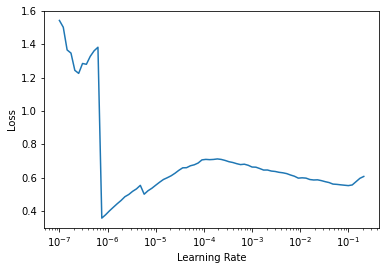

In [ ]:
#colab
%%time
learner.xla_lr_find()

In [ ]:
#hide
#colab
# def train_partial_batches(rank):
#     print(f'xla {rank}: start train partial batches')
#     xm.rendezvous('start_train_partial_batches')
#     world_size = xm.xrt_world_size()
#     device = xm.xla_device()
#     dls = build_distributed_dataloaders(MDLS, rank, world_size, sync_valid=True)
#     model = WRAPPED_MODEL.to(device)
#     learner = Learner(dls, model, loss_func=nn.CrossEntropyLoss(), 
#                       opt_func=Adam,
#                       metrics=accuracy)
#     learner.to_multi_xla(device, rank, sync_valid=True)
#     learner.add_cbs([SyncedCancelCallback()])
#     if xm.is_master_ordinal():
#         cbs = [NumIterCancelCallback(100, on_valid=False)]
#     else:
#         cbs = [NumIterCancelCallback()]
#     learner.fit(5, lr=2e-3, cbs=cbs)
#     learner.save('partial-stage-1', rendezvous=False)
#     xm.rendezvous('end_train_partial_batches')
#     print(f'xla {rank}: end train partial batches')    

In [ ]:
#hide
#colab
# %%time
# xmp.spawn(train_partial_batches, args=(), nprocs=8,
#         start_method='fork')

In [ ]:
#colab
learner.xla_fit(1)

start fit


epoch,train_loss,valid_loss,accuracy,time
0,0.151200,0.250101,0.910511,00:17


start fit


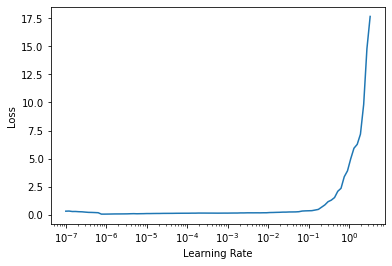

In [ ]:
#colab
suggest_lr = learner.xla_lr_find(stop_div=False)

In [ ]:
#colab
print(suggest_lr)

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)


In [ ]:
# len(learner.recorder.lrs), type(learner.recorder.lrs), len(learner.recorder.losses), type(learner.recorder.losses)

In [ ]:
# print(learner.recorder.losses, learner.recorder.lrs)

In [ ]:
#colab
learner.xla_fit(1)

start fit


epoch,train_loss,valid_loss,accuracy,time
0,0.103489,1.654110,0.616477,00:16


In [ ]:
#colab
learner.unfreeze()

start fit


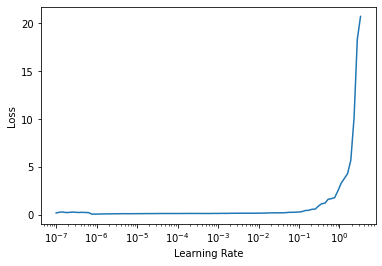

In [ ]:
#colab
suggest_lr = learner.xla_lr_find(stop_div=False)

In [ ]:
#colab
print(suggest_lr)

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=6.309573450380412e-07)


In [ ]:
# len(learner.recorder.lrs), type(learner.recorder.lrs), len(learner.recorder.losses), type(learner.recorder.losses)

In [ ]:
# print(learner.recorder.losses, learner.recorder.lrs)

In [ ]:
#colab
learner.xla_fit_one_cycle(3)

start fit


epoch,train_loss,valid_loss,accuracy,time
0,0.051903,0.543764,0.752841,00:13
1,0.067877,1.030375,0.690341,00:07
2,0.071983,0.573838,0.833807,00:06


In [ ]:
#colab
one_param(learner.model).device


device(type='cpu')

In [ ]:
#colab
learner.dls.device

device(type='cpu')

start fit


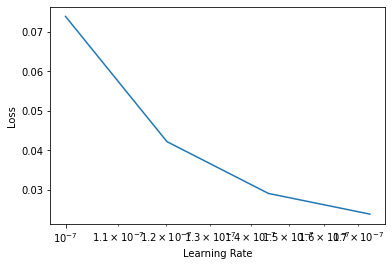

In [ ]:
#colab
learner.xla_lr_find()

In [ ]:
# len(learner.recorder.lrs), type(learner.recorder.lrs), len(learner.recorder.losses), type(learner.recorder.losses)

In [ ]:
#colab
learner.xla_fit(1, lr=1e-2)

start fit


epoch,train_loss,valid_loss,accuracy,time
0,0.417607,77015.023438,0.498580,00:17


In [ ]:
# learner.xla_fit(1, num_cores=1)

## Export -

In [ ]:
#hide
#colab
%cd /content/fastai_xla_extensions
from nbdev.export import notebook2script
notebook2script()

/content/drive/MyDrive/fastai_xla_extensions
Converted 00_core.ipynb.
Converted 01_utils.ipynb.
Converted 02_cifar_loader.ipynb.
Converted 02b_misc_utils.ipynb.
Converted 03_multi_core.base.ipynb.
Converted 03a_multi_core.torch_compat.ipynb.
Converted 03b_multi_core.learner.ipynb.
Converted 03c_multi_core.callback.ipynb.
Converted 03d_multi_core.lr_find.ipynb.
Converted 03e_multi_core.inference.ipynb.
Converted 99_dev_setup.ipynb.
Converted index.ipynb.


In [ ]:
#hide
#colab
from nbdev.export2html import notebook2html
notebook2html()

converting: /content/drive/MyDrive/fastai_xla_extensions/nbs/03b_multi_core.learner.ipynb
converting: /content/drive/MyDrive/fastai_xla_extensions/nbs/03d_multi_core.lr_find.ipynb
converting: /content/drive/MyDrive/fastai_xla_extensions/nbs/03c_multi_core.callback.ipynb
converting: /content/drive/MyDrive/fastai_xla_extensions/nbs/03_multi_core.base.ipynb
